## Let's compare Gauss-Newton method and Method of Three Squares

In [1]:
import numpy as np
from numpy import linalg as lg

In [2]:
class Solution(object):
    """
    search solution in L2 norm
    """
    def resolveByModifiedNewton(self, x0, F, J, L,  eps = 10e-7, needInf = False, maxIter = 1000):
        """
        Inputs:
        x_0 - start point
        Returns :
        x - solution of optimization problem
        """
        iterCount = 1
        x =  x0 - lg.inv(J(x0) + L/2*lg.inv(J(x0).T)).dot(F(x0)) ## поиск argmin(psi)
        while lg.norm(x  - x0) > eps and iterCount < maxIter :
            iterCount += 1
            x0 = x
            x = x0 - lg.inv(J(x0) + L/2*lg.inv(J(x0).T)).dot(F(x0))  ## поиск argmin(psi)
        if needInf:
            return x, iterCount
        return x
    
    def resolveByThreeSquares(self,x_0 , F, J, L, eps = 10e-7, needInf = False, maxIter = 1000):
        """
        Inputs:
        x_0 - start point
        Returns :
        x - solution of optimization problem
        """
        iterCount = 1
        x = x_0 - lg.inv(J(x_0) + L*lg.norm(F(x_0))*lg.inv(J(x_0).T)).dot(F(x_0))  ## поиск argmin(fi)
        while lg.norm(x  - x_0) > eps and iterCount < maxIter : 
            iterCount += 1
            x_0 = x
            x = x_0 - lg.inv(J(x_0) + L*lg.norm(F(x_0))*lg.inv(J(x_0).T)).dot(F(x_0))## поиск argmin(fi)
        if needInf:
            return x, iterCount
        return x
              
        
        def resolveByStochasticSquares(self,x_0 , F, J, L = 1 , eps = 10e-7, needInf = False, maxIter = 1000):
            return 0

In [3]:
def J1(x):
    J = np.zeros((len(x), len(x)))
    J[0][0] =1
    for i in range(1,len(x)):
        J[i][i] = 1
        J[i][i-1] = 4*x[i-1]
    return J

def F1(x):
    F = np.zeros(len(x))
    F[0] = x[0] - 1
    for i in range(1,len(x)):
        F[i] = x[i] - 2*x[i-1]**2 + 1
    return F
        
        
def J2(x):
    J = np.zeros((len(x), len(x)))
    J[0][0] =1
    for i in range(1,len(x)):
        J[i][i] = 1
        J[i][i-1] = np.pi*2*np.sin(x[i-1])*np.cos(x[i-1])
    return J     


def F2(x):
    F = np.zeros(len(x))
    F[0] = x[0] - 1
    for i in range(1,len(x)):
        F[i] = x[i] - 2*np.sin(np.pi*x[i-1]/2)**2 + 1
    return F

### Testing F1

In [4]:
import time

sol = Solution()

timeN = []
timeT = []
iterT = []
iterN = []
maxSTEP = 11
for i in range(1,maxSTEP):
    #print(i)
    x_0 = np.ones(i)
    x_0[0] = -1
    t = time.clock()
    x_n, it = sol.resolveByModifiedNewton(x_0,F2, J2, 90, eps = 10e-3, needInf = True )
    timeN += [time.clock() - t]
    iterN += [it]
    #print("timeN : " + str(timeN[-1]) + "  iterN : " + str(iterN[-1]))
    
    t = time.clock()
    x_t, it = sol.resolveByThreeSquares(x_0,F2, J2, 90, eps = 10e-3, needInf = True)
    timeT += [time.clock() - t]
    iterT += [it]
    #print("timeT : " + str(timeT[-1]) + "  iterT : " + str(iterT[-1]))
    


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## Iterations

In [5]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(range(1,maxSTEP), iterN, 'rx', range(1,maxSTEP), iterT, 'b+', linestyle='solid')
lgnd = ax.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
ax.set_xlabel('n')
ax.set_ylabel('iterations')
ax.set_title('plot of iterations versus function dimension')

Text(0.5, 1.0, 'plot of iterations versus function dimension')

## Time

Text(0.5, 1.0, 'plot of time versus function dimension')

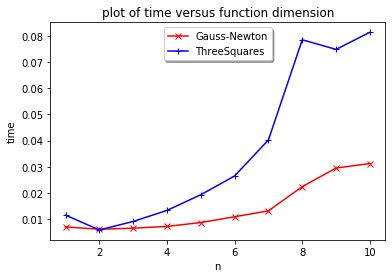

In [6]:
ax = plt.gca()
ax.plot(range(1,maxSTEP), timeN, 'rx', range(1,maxSTEP), timeT, 'b+', linestyle='solid')
lgnd = ax.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
ax.set_xlabel('n')
ax.set_ylabel('time')
ax.set_title('plot of time versus function dimension')

### Testing F2

In [7]:
import time
sol = Solution()

timeN = []
timeT = []
iterT = []
iterN = []
maxSTEP = 11
for i in range(1,maxSTEP):
    #print(i)
    x_0 = np.ones(i)
    x_0[0] = -1
    t = time.clock()
    x_n, it = sol.resolveByModifiedNewton(x_0,F1, J1, 90, eps = 10e-3, needInf = True )
    timeN += [time.clock() - t]
    iterN += [it]
    #print("timeN : " + str(timeN[-1]) + "  iterN : " + str(iterN[-1]))
    
    t = time.clock()
    x_t, it = sol.resolveByThreeSquares(x_0,F1, J1, 90, eps = 10e-3, needInf = True)
    timeT += [time.clock() - t]
    iterT += [it]
    #print("timeT : " + str(timeT[-1]) + "  iterT : " + str(iterT[-1]))
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## Iterations

Text(0.5, 1.0, 'plot of iterations versus function dimension')

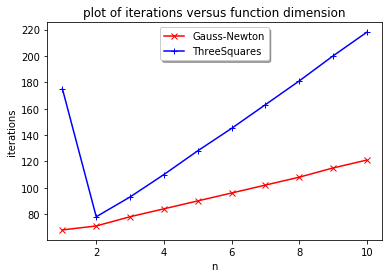

In [8]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(range(1,maxSTEP), iterN, 'rx', range(1,maxSTEP), iterT, 'b+', linestyle='solid')
lgnd = ax.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
ax.set_xlabel('n')
ax.set_ylabel('iterations')
ax.set_title('plot of iterations versus function dimension')

## Time

Text(0.5, 1.0, 'plot of time versus function dimension')

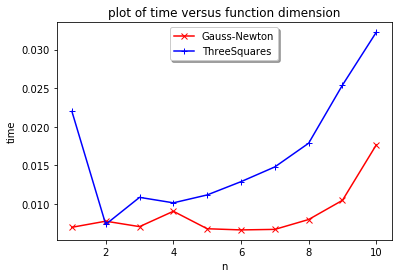

In [9]:
ax = plt.gca()
ax.plot(range(1,maxSTEP), timeN, 'rx', range(1,maxSTEP), timeT, 'b+', linestyle='solid')
lgnd = ax.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
ax.set_xlabel('n')
ax.set_ylabel('time')
ax.set_title('plot of time versus function dimension')